# Evaluate Trends in misinformation on Twitter in the run-up to the 2020 US Presidential Elections

# Team Members
Abhishek Bais, Jimmy Liang, Rohan Kumar, Samer Baslan

# Import packages

In [2]:
# Import standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm, dates
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import string, collections, unicodedata
import missingno as msno

# Import NLP libraries
import re
import nltk
import json
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

# Import models, evaluator libraries
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score 
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

# Import location, time libraries
import os
import time
from datetime import datetime, timedelta

%matplotlib inline

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
!pip install langdetect


In [3]:
!pip install geopandas

In [4]:
# Mount Google Drive
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Utlity APIs

# Data pre-processing utlity APIs

In [5]:
# Read in the common word phrases
with open('/content/drive/My Drive/256/256_common_word_phrases.json', 'r') as f:
    phrases_dict = json.load(f)
phrases = phrases_dict['phrases']
phrases

{"'cause": 'because',
 "ain't": 'am not / are not',
 "aren't": 'are not / am not',
 "can't": 'cannot',
 "can't've": 'cannot have',
 "could've": 'could have',
 "couldn't": 'could not',
 "couldn't've": 'could not have',
 "didn't": 'did not',
 "doesn't": 'does not',
 "don't": 'do not',
 "hadn't": 'had not',
 "hadn't've": 'had not have',
 "hasn't": 'has not',
 "haven't": 'have not',
 "he'd": 'he had / he would',
 "he'd've": 'he would have',
 "he'll": 'he shall / he will',
 "he'll've": 'he shall have / he will have',
 "he's": 'he has / he is',
 "how'd": 'how did',
 "how'd'y": 'how do you',
 "how'll": 'how will',
 "how's": 'how has / how is',
 "i'd": 'I had / I would',
 "i'd've": 'I would have',
 "i'll": 'I shall / I will',
 "i'll've": 'I shall have / I will have',
 "i'm": 'I am',
 "i've": 'I have',
 "isn't": 'is not',
 "it'd": 'it had / it would',
 "it'd've": 'it would have',
 "it'll": 'it shall / it will',
 "it'll've": 'it shall have / it will have',
 "it's": 'it has / it is',
 "let's": 'l

In [6]:
# Stop words for lemma
stop_words = set(stopwords.words('english'))
stop_words.add('https')
stop_words.add('http')

In [7]:
# Pre-process emojis
def preprocess_emojis(text):
    text = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:|:-/|:-\|)', ' negative ', text) # Sad
    text = re.sub(r'(:,\(|:\'\(|:"\()', ' negative ', text)                  # Weep
    text = re.sub(r'(<3|:\*)', ' positive ', text)                           # Love
    text = re.sub(r'(;-?\)|;-?D|\(-?;|@-\))', ' positive ', text)            # Wink
    text = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' positive ', text)              # Laughs
    text = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\)|:O)', ' positive ', text) # Smileys
    return text

In [8]:
# Pre-process tweet
def preprocess_text(text):
    preprocess_emojis(text)
    text = text.lower()                                             # To lower
    text = re.sub(r"\d+", " ", str(text))                           # Delete numbers
    text = re.sub('&quot;'," ", text)                               # Delete &quot;
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', ' ', text)   # Delete link
    text = re.sub('@[^\s]+', '', text)                              # Delete user info
    text = re.sub(r"\b[a-zA-Z]\b", "", str(text))                   # Delete one chars
    text = re.sub(r"[^\w\s]", " ", str(text))                       # Delete punctuations
    text = re.sub(r"\s+", " ", str(text))                           # Clean double space
    text = re.sub(r'(.)\1+', r'\1\1', text)                         # Clean multiple repeats
    for word in text.split():
        if word.lower() in phrases:
            text = text.replace(word, phrases[word.lower()])        # Swap common word phrases
    return text

In [9]:
# Custom lemmatize and split text into words for ngram visualization
def custom_lemmatize(text):
  text = (unicodedata.normalize('NFKD', text)
         .encode('ascii', 'ignore')
         .decode('utf-8', 'ignore')
         .lower())
  wnl = WordNetLemmatizer()
  words = re.sub(r'[^\w\s]', '', text).split()
  return [wnl.lemmatize(word) for word in words if word not in stop_words and len(word)>3]

In [10]:
# Clean the tweet for ngram visualization
def clean_tweet(text):
    preprocess_text(text)
    cleaned_text=""
    text = (unicodedata.normalize('NFKD', text)
            .encode('ascii', 'ignore')
            .decode('utf-8', 'ignore')
            .lower())
    text = re.sub(r'#.+|https.+|[^(a-zA-Z)\s]','',text)
    words=text.split()
    for word in words:
        if word not in stop_words:
            cleaned_text=cleaned_text+' '+word
    return cleaned_text

In [11]:
# Custom lemmatize and recreate text for sentiment analysis
def custom_lemmatize_and_join(text):
  text = (unicodedata.normalize('NFKD', text)
         .encode('ascii', 'ignore')
         .decode('utf-8', 'ignore')
         .lower())
  lemmatizer = WordNetLemmatizer()
  word_list = text.split()        
  text = ' '.join([lemmatizer.lemmatize(w) for w in word_list if not w in stop_words and len(w)>3])   
  return text

In [12]:
# Pre-process tweet to prepare clean, lemma tweet for sentiment analysis
def preprocess_tweet(text):
    preprocess_emojis(text)
    text = text.lower()                                             # To lower
    text = re.sub(r"\d+", " ", str(text))                           # Delete numbers
    text = re.sub('&quot;'," ", text)                               # Delete &quot;
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', ' ', text)   # Delete link
    text = re.sub('@[^\s]+', '', text)                              # Delete user info
    text = re.sub(r"\b[a-zA-Z]\b", "", str(text))                   # Delete one chars
    text = re.sub(r"[^\w\s]", " ", str(text))                       # Delete punctuations
    text = re.sub(r"\s+", " ", str(text))                           # Clean double space
    text = re.sub(r'(.)\1+', r'\1\1', text)                         # Clean multiple repeats
    for word in text.split():
        if word.lower() in phrases:
            text = text.replace(word, phrases[word.lower()])        # Swap common word phrases
    custom_lemmatize_and_join(text)
    return text

# Data visualization utlity APIs

In [13]:
# Plot word cloud
def generate_word_cloud(stop_words, text):
  plt.figure(figsize=(10,10))
  wordcloud = WordCloud(stopwords=stop_words, 
                      background_color="black", max_words=2500,
                      max_font_size=256, random_state=101,
                      width=1600, height=1600).generate(str(text.dropna()))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.show()

In [14]:
# Generate dates
from matplotlib.ticker import FuncFormatter
@plt.FuncFormatter
def fake_dates(x, pos):
    """ Custom formater to turn floats into e.g., 05-08"""
    return dates.num2date(x).strftime('%m-%d')

In [15]:
# Utilities to heatmap for tweet origin, outlet medium and by language
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
barcolors = ['#87B88C','#9ED2A1','#E7E8CB','#48A0C9','#2A58A1','#2E8B55','#DF3659','Grey']
barstyle = {"edgecolor":"black", "linewidth":1}
heatmap1_args = dict(annot=True, fmt='.0f', square=False, cmap=cm.get_cmap("RdGy", 10), center = 90, vmin=0, vmax=10000, lw=4, cbar=False)
heatmap2_args = dict(annot=True, fmt='.3f', square=False, cmap="Greens", center = 0.5, lw=4, cbar=False)
heatmap3_args = dict(annot=True, fmt='.0f', square=False, cmap=cmap, center = 9200, lw=4, cbar=False)

# Function to hide axis
def hide_axes(this_ax):
    this_ax.set_frame_on(False)
    this_ax.set_xticks([])
    this_ax.set_yticks([])
    return this_ax

def thousands1(x, pos):
    'The two args are the value and tick position'
    return '%1.0fK' % (x * 1e-3)

formatterK1 = FuncFormatter(thousands1)
def thousands2(x, pos):
    'The two args are the value and tick position'
    return '%1.1fK' % (x * 1e-3)

formatterK2 = FuncFormatter(thousands2)

In [16]:
# Function to plot tweet source
def draw_heatmap(df, this_ax, heat_map_args):
    hm = sns.heatmap(df, ax = this_ax, **heat_map_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top','bottom','left','right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm 

In [17]:
# Function to plot n-grams
def generate_ngram(ngram_left, ngram_right, title_left, title_right, color_scheme):
  fig, ax=plt.subplots(1,2, figsize=(8,16), 
                       gridspec_kw={'width_ratios':[1,1], 'wspace':0.1, 'hspace':0.1})
  if (color_scheme == 0):
    # real vs fake news
    left_color = 'peru'
    right_color = 'teal'
  else:
    # biden vs trump
    left_color = 'blue'
    right_color = 'red'
  
  # left n-gram fake news/ biden
  left_box = ax[0]
  ngram_left[::-1].plot.barh(ax=left_box, color=left_color,**barstyle)
  left_box.yaxis.set_label_position("left")
  left_box.xaxis.tick_top()
  left_box.xaxis.set_label_position("top")
  left_box.xaxis.set_major_formatter(formatterK2)
  left_box.set_xlim([0, 3500])
  left_box.set_xlim(left_box.get_xlim()[::-1])
  left_box.set_xlabel(title_left)
  left_box.set_ylabel('')

  # right n-gram real news/ trump
  right_box = ax[1]
  ngram_right[::-1].plot.barh(ax=right_box, color=right_color,**barstyle)
  right_box.xaxis.tick_top()
  right_box.xaxis.set_label_position("top")
  right_box.xaxis.set_major_formatter(formatterK2)
  right_box.set_xlim([0, 3500])
  right_box.set_xlim(right_box.get_xlim())
  right_box.yaxis.tick_right()
  right_box.set_xlabel(title_right)
  right_box.set_ylabel('')
  plt.show()

# Training Data Exploration

# Peak at the fake news training dataset

In [35]:
# Peek at the real news dataset, excluding the first, second column
df_fake_news = pd.read_csv('/content/drive/My Drive/255/datasets/fake_news.csv', ).iloc[:, 2:]
df_fake_news.head(5)

,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type
0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,english,2016-10-27T01:49:27.168+03:00,100percentfedup.com,US,25689.0,Muslims BUSTED: They Stole Millions In Gov’t B...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
1,reasoning with facts,2016-10-29T08:47:11.259+03:00,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,english,2016-10-29T08:47:11.259+03:00,100percentfedup.com,US,25689.0,Re: Why Did Attorney General Loretta Lynch Ple...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
2,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,english,2016-10-31T01:41:49.479+02:00,100percentfedup.com,US,25689.0,BREAKING: Weiner Cooperating With FBI On Hilla...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
3,Fed Up,2016-11-01T05:22:00.000+02:00,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,english,2016-11-01T15:46:26.304+02:00,100percentfedup.com,US,25689.0,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,0.068,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias
4,Fed Up,2016-11-01T21:56:00.000+02:00,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,english,2016-11-01T23:59:42.266+02:00,100percentfedup.com,US,25689.0,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,0.865,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias


In [36]:
# Report the number of entries in fake news dataset
df_fake_news.shape

(12999, 18)

In [37]:
# Inspect the dataset to find missing entries
df_fake_news.isnull().sum()

author                2424
published                0
title                  680
text                    46
language                 0
crawled                  0
site_url                 0
country                176
domain_rank           4223
thread_title            12
spam_score               0
main_img_url          3643
replies_count            0
participants_count       0
likes                    0
comments                 0
shares                   0
type                     0
dtype: int64

In [38]:
# Fill columns with missing title with null string
df_fake_news['title'].fillna("", inplace=True)
df_fake_news.isnull().sum()
df_fake_news.shape

(12999, 18)

# Fake News training data exploration

In [39]:
# Report unique authors of fake news
df_fake_news['author'].value_counts().head(10)

admin                                    247
Starkman                                 100
Eddy Lavine                              100
Alex Ansary                              100
Editor                                   100
Pakalert                                 100
Gillian                                  100
BareNakedIslam                            99
noreply@blogger.com (Alexander Light)     99
Dave Hodges                               99
Name: author, dtype: int64

# Fake news by type 

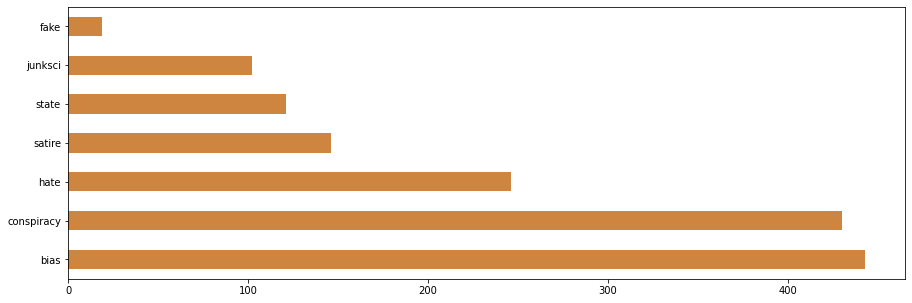

In [40]:
# Report fake news by type, excluding bs news
plt.figure(figsize=(15,5), edgecolor='b')
df_fake_news[df_fake_news['type'] != 'bs']['type'].value_counts().plot(kind="barh", color='peru')

# Fake News country of origin

Text(0.5, 1.0, 'Top 6 countries fake news originating from')

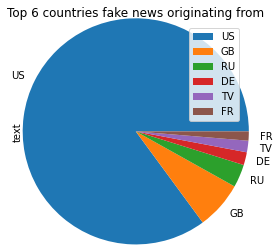

In [25]:
# Report fake news by type, excluding bs news
sources=pd.DataFrame(df_fake_news.groupby(['country'])['text'].count().sort_values(ascending=False)[:6])
sources.plot(kind = 'pie', x = 'country', y = 'text', radius=1.3)
plt.title("Top 6 countries fake news originating from")

In [41]:
# Drop entries with null text
# Drop unwanted columns
df_fake_news.dropna(subset=['text'], axis=0, inplace=True)
df_fake_news.drop(['author','country','domain_rank','main_img_url','thread_title'], axis=1, inplace=True)
df_fake_news.reset_index(drop=True, inplace=True)
df_fake_news.isnull().sum()

published             0
title                 0
text                  0
language              0
crawled               0
site_url              0
spam_score            0
replies_count         0
participants_count    0
likes                 0
comments              0
shares                0
type                  0
dtype: int64

# Fake News word cloud

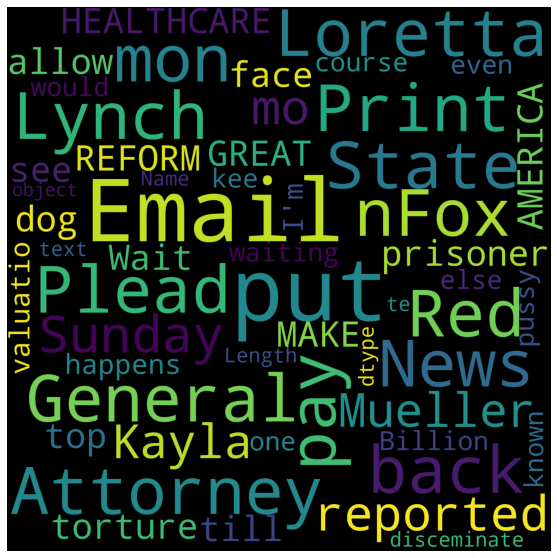

In [27]:
# Plot the word cloud of fake news content
text=df_fake_news['text']
generate_word_cloud(stop_words, text)

# Fake News unique news sources

Text(0.5, 1.0, 'Publications')

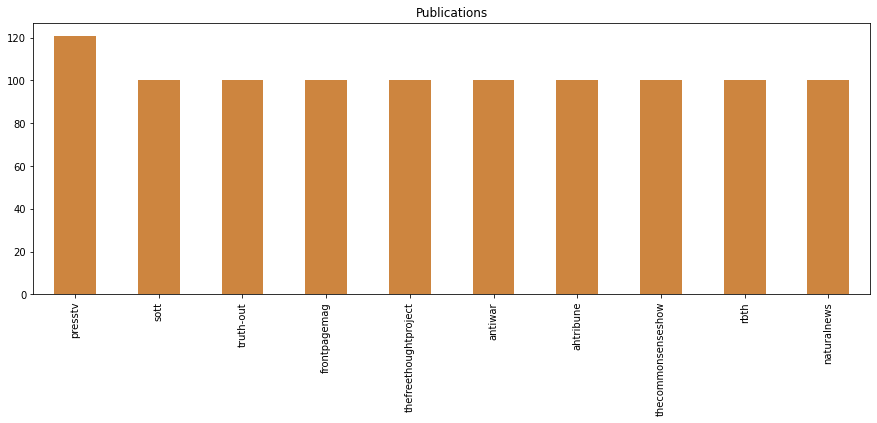

In [42]:
# Plot sources of fake news
df_fake_news['site_url'] = df_fake_news['site_url'].apply(lambda x:x.split(".")[0])
plt.figure(figsize=(15,5))
df_fake_news['site_url'].value_counts().head(10).plot(kind="bar",color='peru')
plt.title('Publications')

# Peak at the real news training dataset

In [43]:
# Peek at the real news dataset, excluding the first, second column
df_real_news = pd.read_csv('/content/drive/My Drive/255/datasets/real_news.csv', ).iloc[:, 2:]
df_real_news.head(5)

,id,title,publication,author,date,year,month,url,content
0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...
1,17291,"First, a Mixtape. Then a Romance. - The New Yo...",New York Times,Katherine Rosman,2016-12-31,2016.0,12.0,NaN,"Just how is Hillary Kerr, the founder of ..."
2,17292,Calling on Angels While Enduring the Trials of...,New York Times,Andy Newman,2016-12-31,2016.0,12.0,NaN,Angels are everywhere in the Muñiz family’s ap...
3,20127,U.S. Plans to Step Up Military Campaign Agains...,New York Times,Michael S. Schmidt and Eric Schmitt,2016-12-21,2016.0,12.0,NaN,"ABU DHABI, United Arab Emirates — The Obama..."
4,20131,272 Slaves Were Sold to Save Georgetown. What ...,New York Times,Rachel L. Swarns,2016-12-15,2016.0,12.0,NaN,WASHINGTON — The human cargo was loaded on ...


In [44]:
# Report the number of real news in dataset
df_real_news.shape

(15712, 9)

In [45]:
# Inspect the dataset to find missing entries
df_real_news.isnull().sum()

id                0
title             0
publication       0
author         1745
date              0
year              0
month             0
url            4611
content           0
dtype: int64

In [32]:
# Drop the columns author, url as they contain missing entries
df_real_news.drop(['author','url'],axis=1, inplace=True)
df_real_news.isnull().sum()
df_real_news.shape

(15712, 7)

# Real News exploration

In [33]:
# Report the unique sources of real news
df_real_news['publication'].value_counts().head(10)

Reuters            2307
NPR                2014
Washington Post    1886
Guardian           1880
CNN                1624
Atlantic           1558
New York Times     1428
Fox News           1132
National Review     973
Vox                 910
Name: publication, dtype: int64

# Real News word cloud

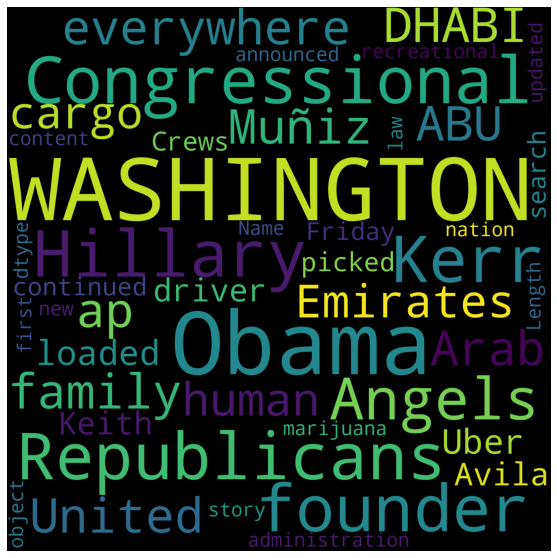

In [34]:
# Plot the word cloud of real news content
text=df_real_news['content']
generate_word_cloud(stop_words, text)

# Real News unique news sources

Text(0.5, 1.0, 'Publications')

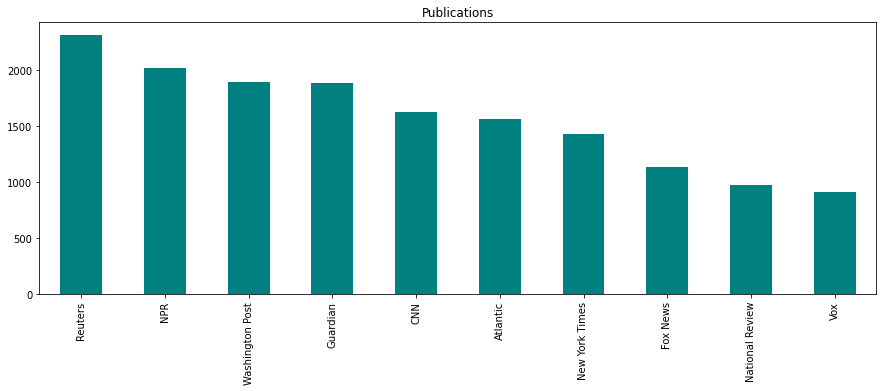

In [35]:
# Plot the unique news sources
plt.figure(figsize=(15,5))
df_real_news['publication'].value_counts().plot(kind="bar", color='teal')
plt.title('Publications')

# Fake, Real News bi, tri gram

In [ ]:
# Get the text/ content of fake/ real news
text1=df_fake_news['text']
text2=df_real_news['content']

In [ ]:
# Generate bi/tri gram from fake/real news
# Get the words from the text/ content
words1 = custom_lemmatize(''.join(str(text1.apply(clean_tweet).tolist())))
words2 = custom_lemmatize(''.join(str(text2.apply(clean_tweet).tolist())))

# Get the bi/ tri grams from the words
fake_news_2ngrams=(pd.Series(nltk.ngrams(words1, 2)).value_counts())[:10]
real_news_2ngrams=(pd.Series(nltk.ngrams(words2, 2)).value_counts())[:10]
fake_news_3ngrams=(pd.Series(nltk.ngrams(words1, 3)).value_counts())[:10]
real_news_3ngrams=(pd.Series(nltk.ngrams(words2, 3)).value_counts())[:10]

# Plot the bi/tri grams
fake_news_ngrams=pd.concat([fake_news_2ngrams, fake_news_3ngrams])
real_news_ngrams=pd.concat([real_news_2ngrams, real_news_3ngrams])

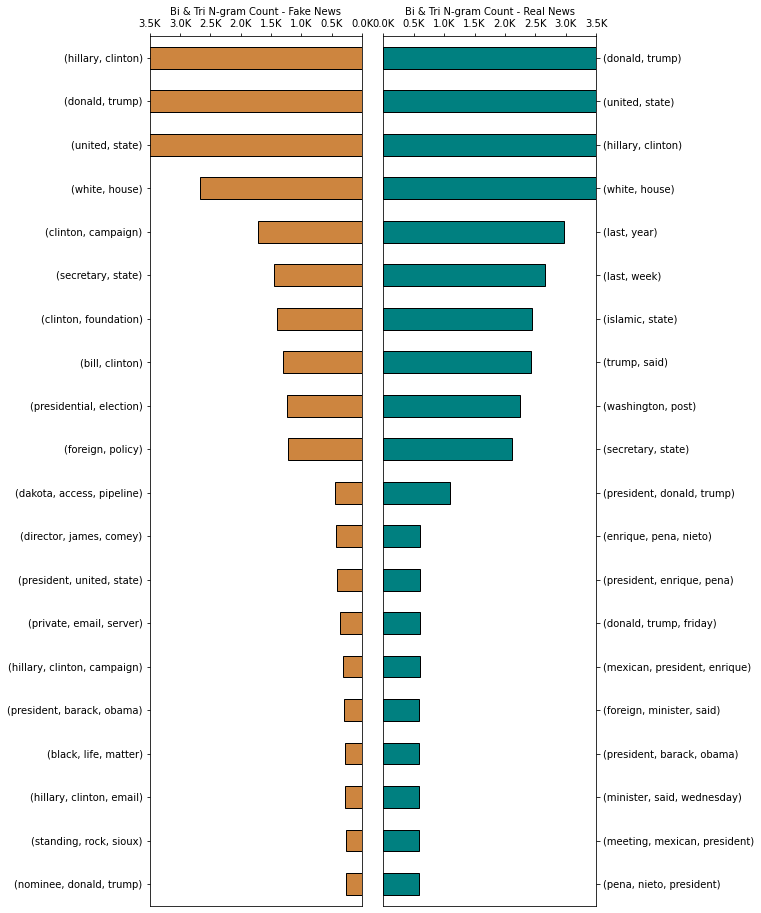

In [ ]:
generate_ngram(fake_news_ngrams, real_news_ngrams, "Bi & Tri N-gram Count - Fake News", "Bi & Tri N-gram Count - Real News", 0)

# Merge real, fake news in prep for data modelling

In [46]:
df_fake_news = df_fake_news[['title', 'text','site_url']]
df_fake_news['type'] = 'fake'
df_fake_news.head(5)

,title,text,site_url,type
0,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,100percentfedup,fake
1,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,100percentfedup,fake
2,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,100percentfedup,fake
3,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,100percentfedup,fake
4,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,100percentfedup,fake


In [47]:
df_fake_news.isnull().sum()

title       0
text        0
site_url    0
type        0
dtype: int64

In [48]:
# Prune unwanted columns in fake news
# Treat hate, satire, conspiracy, fake news in fake news dataset as fake news
df_fake_news.dropna(subset=['text'], axis=0, inplace=True)
df_fake_news['site_url'] = df_fake_news['site_url'].apply(lambda x:x.split('.')[0])
df_fake_news['title'].fillna("", inplace=True)
df_fake_news.dropna(inplace=True)
df_fake_news.reset_index(drop=True, inplace=True)
df_fake_news.columns = ['title','content','publication','type']
df_fake_news.isnull().sum()

title          0
content        0
publication    0
type           0
dtype: int64

In [49]:
# Prune unwanted columns in real news
df_real_news = df_real_news[['title', 'content', 'publication']]
df_real_news['type'] = 'real'
df_real_news.columns = ['title','content','publication','type']
df_real_news.isnull().sum()

title          0
content        0
publication    0
type           0
dtype: int64

In [50]:
# Prepare clean dataset of real, fake news
all_news = pd.concat([df_fake_news, df_real_news])
all_news.reset_index(drop=True, inplace=True)
all_news.head(5)

,title,content,publication,type
0,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,100percentfedup,fake
1,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,100percentfedup,fake
2,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,100percentfedup,fake
3,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,100percentfedup,fake
4,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,100percentfedup,fake


In [51]:
# Report real, fake news entries post pre-processing
all_news.shape

(28665, 4)

# Visualize title, content characteristics of fake, real news

In [37]:
all_news['title_length'] = all_news['title'].apply(len)
all_news['content_length'] = all_news['content'].apply(len)
all_news['title_ucase_length'] = all_news['title'].apply(lambda x:len(re.findall('([A-Z])', x)))
all_news['content_ucase_length'] = all_news['content'].apply(lambda x:len(re.findall('([A-Z])', x)))
all_news['title_punctuation_length'] = all_news['title'].apply(lambda x:len(re.sub(r'[^\w\s]','',x)))
all_news['content_punctuation_length'] = all_news['content'].apply(lambda x:len(re.sub(r'[^\w\s]','',x)))
all_news['content'] = all_news['title']+', '+all_news['content']
all_news

,title,content,publication,type,title_length,content_length,title_ucase_length,content_ucase_length,title_punctuation_length,content_punctuation_length
0,Muslims BUSTED: They Stole Millions In Gov’t B...,Muslims BUSTED: They Stole Millions In Gov’t B...,100percentfedup,fake,53,505,13,12,51,494
1,Re: Why Did Attorney General Loretta Lynch Ple...,Re: Why Did Attorney General Loretta Lynch Ple...,100percentfedup,fake,59,1789,10,68,57,1736
2,BREAKING: Weiner Cooperating With FBI On Hilla...,BREAKING: Weiner Cooperating With FBI On Hilla...,100percentfedup,fake,68,1363,18,37,67,1323
3,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,100percentfedup,fake,125,271,44,14,118,265
4,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,100percentfedup,fake,99,2095,32,91,94,2058
...,...,...,...,...,...,...,...,...,...,...
28660,An eavesdropping Uber driver saved his 16-year...,An eavesdropping Uber driver saved his 16-year...,Washington Post,real,87,4563,2,148,84,4383
28661,Plane carrying six people returning from a Cav...,Plane carrying six people returning from a Cav...,Washington Post,real,83,3514,4,171,83,3372
28662,After helping a fraction of homeowners expecte...,After helping a fraction of homeowners expecte...,Washington Post,real,105,6911,2,179,103,6744
28663,"Yes, this is real: Michigan just banned bannin...","Yes, this is real: Michigan just banned bannin...",Washington Post,real,60,4133,2,85,58,4035


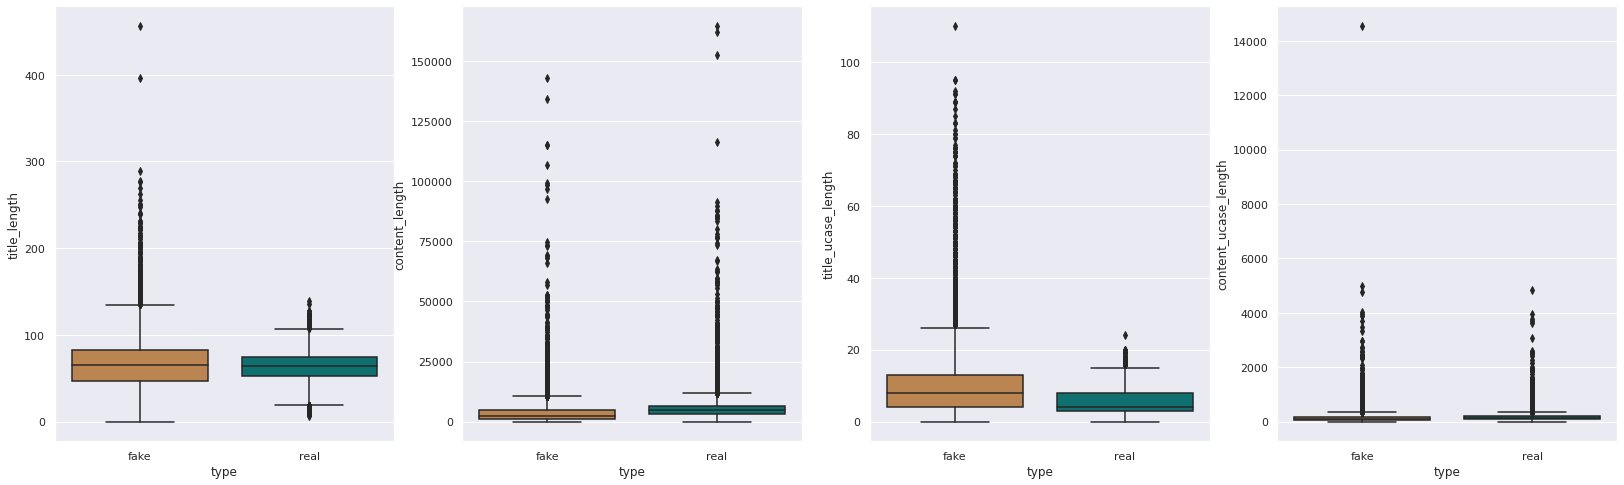

In [38]:
# Plot the fake, real news characteristics
sns.set(rc={'figure.figsize':(28,8)})
fig, ax = plt.subplots(ncols=4)
my_colors = {"fake": "peru", "real": "teal"}

# Real vs fake news - title length
sns.boxplot(x='type', y='title_length', data=all_news, ax=ax[0],palette=my_colors)

# Real vs fake news - content length
sns.boxplot(x='type', y='content_length', data=all_news, ax=ax[1],palette=my_colors)

# Real vs fake news - title uppercase length
sns.boxplot(x="type", y="title_ucase_length", data=all_news, ax=ax[2],palette=my_colors)

# Real vs fake news - title uppercase length
sns.boxplot(x="type", y="content_ucase_length", data=all_news, ax=ax[3],palette=my_colors)

# Clean and Lemma merged fake, real news

In [52]:
# Clean, Lemma fake news tweets
all_news['preprocessed_tweet'] = all_news.content.apply(preprocess_tweet)

# Test Data Exploration

# Read in tweets referencing Joe Biden and Donald Trump

In [53]:
# Read in tweets referencing Joe Biden and Donald Trump
df_biden = pd.read_csv('/content/drive/My Drive/255/datasets/hashtag_joebiden.csv', lineterminator='\n', parse_dates=True)
df_trump = pd.read_csv('/content/drive/My Drive/255/datasets/hashtag_donaldtrump.csv', lineterminator='\n', parse_dates=True)

In [54]:
# Report the number of entries in biden dataset
df_biden.shape

(776886, 21)

In [55]:
# Report Biden data
df_biden.head(5)

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,user_join_date,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at
0,2020-10-15 00:00:01,1.316529e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,3.606665e+08,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa...,2011-08-23 15:33:45,1860.0,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00
1,2020-10-15 00:00:18,1.316529e+18,#HunterBiden #HunterBidenEmails #JoeBiden #Joe...,0.0,0.0,Twitter for iPad,8.099044e+08,Cheri A. 🇺🇸,Biloximeemaw,"Locked and loaded Meemaw. Love God, my family ...",2012-09-08 01:03:57,6628.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.517827283
2,2020-10-15 00:00:20,1.316529e+18,@IslandGirlPRV @BradBeauregardJ @MeidasTouch T...,0.0,0.0,Twitter Web App,3.494182e+09,Flag Waver,Flag_Wavers,NaN,2015-08-30 19:38:21,1536.0,Golden Valley Arizona,46.304036,-109.171431,NaN,United States of America,North America,Montana,MT,2020-10-21 00:00:01.035654566
3,2020-10-15 00:00:21,1.316529e+18,@chrislongview Watching and setting dvr. Let’s...,0.0,0.0,Twitter for iPhone,8.242596e+17,Michelle Ferg,MichelleFerg4,NaN,2017-01-25 14:16:17,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:01.553481849
4,2020-10-15 00:00:22,1.316529e+18,#censorship #HunterBiden #Biden #BidenEmails #...,1.0,0.0,Twitter Web App,1.032807e+18,the Gold State,theegoldstate,A Silicon Valley #independent #News #Media #St...,2018-08-24 01:49:01,390.0,"California, USA",36.701463,-118.755997,NaN,United States of America,North America,California,CA,2020-10-21 00:00:02.071309132


In [56]:
# Inspect biden data for missing entries
df_biden.isnull().sum()

created_at                   0
tweet_id                     0
tweet                        0
likes                        0
retweet_count                0
source                     713
user_id                      0
user_name                   18
user_screen_name             0
user_description         82006
user_join_date               0
user_followers_count         0
user_location           233791
lat                     421593
long                    421593
city                    590014
country                 423107
continent               423089
state                   516691
state_code              532277
collected_at                 0
dtype: int64

In [57]:
# Report the number of entries in trump dataset
df_trump.shape

(970919, 21)

In [58]:
# Report Trump data
df_trump.head(5)

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,user_join_date,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at
0,2020-10-15 00:00:01,1.316529e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,3.606665e+08,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa...,2011-08-23 15:33:45,1860.0,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00
1,2020-10-15 00:00:01,1.316529e+18,"Usa 2020, Trump contro Facebook e Twitter: cop...",26.0,9.0,Social Mediaset,3.316176e+08,Tgcom24,MediasetTgcom24,Profilo ufficiale di Tgcom24: tutte le notizie...,2011-07-08 13:12:20,1067661.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.373216530
2,2020-10-15 00:00:02,1.316529e+18,"#Trump: As a student I used to hear for years,...",2.0,1.0,Twitter Web App,8.436472e+06,snarke,snarke,"Will mock for food! Freelance writer, blogger,...",2007-08-26 05:56:11,1185.0,Portland,45.520247,-122.674195,Portland,United States of America,North America,Oregon,OR,2020-10-21 00:00:00.746433060
3,2020-10-15 00:00:02,1.316529e+18,2 hours since last tweet from #Trump! Maybe he...,0.0,0.0,Trumpytweeter,8.283556e+17,Trumpytweeter,trumpytweeter,"If he doesn't tweet for some time, should we b...",2017-02-05 21:32:17,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:01.119649591
4,2020-10-15 00:00:08,1.316529e+18,You get a tie! And you get a tie! #Trump ‘s ra...,4.0,3.0,Twitter for iPhone,4.741380e+07,Rana Abtar - رنا أبتر,Ranaabtar,"Washington Correspondent, Lebanese-American ,c...",2009-06-15 19:05:35,5393.0,Washington DC,38.894992,-77.036558,Washington,United States of America,North America,District of Columbia,DC,2020-10-21 00:00:01.492866121


In [59]:
# Inspect trump data for missing entries
df_trump.isnull().sum()

created_at                   0
tweet_id                     0
tweet                        0
likes                        0
retweet_count                0
source                     876
user_id                      0
user_name                   16
user_screen_name             0
user_description        101266
user_join_date               0
user_followers_count         0
user_location           294953
lat                     525200
long                    525200
city                    743732
country                 528171
continent               528154
state                   650299
state_code              670494
collected_at                 0
dtype: int64

# Clean, Lemma Biden tweets

In [60]:
# Clean, Lemma, vectorize the Biden tweets
df_biden['preprocessed_tweet'] = df_biden.tweet.apply(preprocess_tweet)

In [62]:
# Report original and clean, lemma, stemmed Biden tweets
pd.set_option('display.max_colwidth', 0)
df_biden.head(3)

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,user_join_date,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at,preprocessed_tweet
0,2020-10-15 00:00:01,1.316529e+18,#Elecciones2020 | En #Florida: #JoeBiden dice que #DonaldTrump solo se preocupa por él mismo. El demócrata fue anfitrión de encuentros de electores en #PembrokePines y #Miramar. Clic AQUÍ ⬇️⬇️⬇️\n⠀\n🌐https://t.co/qhIWpIUXsT\n_\n#ElSolLatino #yobrilloconelsol https://t.co/6FlCBWf1Mi,0.0,0.0,TweetDeck,3.606665e+08,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa este de #EEUU\n⠀⏹️ Facebook e Instagram\n⠀🏙️ Philadelphia: /elsollatinonewspaper\n⠀🌅 Miami: /elsollatinonewsmiami,2011-08-23 15:33:45,1860.0,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00,elecciones en florida joebiden dice que donaldtrump solo se preocupa por él mismo el demócrata fue anfitrión de encuentros de electores en pembrokepines miramar clic aquí _ elsollatino yobrilloconelsol flcbwf mi
1,2020-10-15 00:00:18,1.316529e+18,#HunterBiden #HunterBidenEmails #JoeBiden #JoeBidenMustStepDown https://t.co/9enmxWvePm,0.0,0.0,Twitter for iPad,8.099044e+08,Cheri A. 🇺🇸,Biloximeemaw,"Locked and loaded Meemaw. Love God, my family and my country. I will fight til my last breath for my children and grand children's freedoms. Trump2020",2012-09-08 01:03:57,6628.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.517827283,hunterbiden hunterbidenemails joebiden joebidenmuststepdown enmxwvepm
2,2020-10-15 00:00:20,1.316529e+18,@IslandGirlPRV @BradBeauregardJ @MeidasTouch This is how #Biden made his ! #TrumpIsNotAmerica !\nhttps://t.co/uBqAFU86Ip,0.0,0.0,Twitter Web App,3.494182e+09,Flag Waver,Flag_Wavers,NaN,2015-08-30 19:38:21,1536.0,Golden Valley Arizona,46.304036,-109.171431,NaN,United States of America,North America,Montana,MT,2020-10-21 00:00:01.035654566,this is how biden made his trumpisnotamerica ip


# Clean, Lemma Trump tweets

In [61]:
# Clean, Lemma the Trump tweets
df_trump['preprocessed_tweet'] = df_trump.tweet.apply(preprocess_tweet)

In [63]:
# Report original and clean, lemma, stemmed Trump tweets
pd.set_option('display.max_colwidth', 0)
df_trump.head(3)

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,user_join_date,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at,preprocessed_tweet
0,2020-10-15 00:00:01,1.316529e+18,#Elecciones2020 | En #Florida: #JoeBiden dice que #DonaldTrump solo se preocupa por él mismo. El demócrata fue anfitrión de encuentros de electores en #PembrokePines y #Miramar. Clic AQUÍ ⬇️⬇️⬇️\n⠀\n🌐https://t.co/qhIWpIUXsT\n_\n#ElSolLatino #yobrilloconelsol https://t.co/6FlCBWf1Mi,0.0,0.0,TweetDeck,360666534.0,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa este de #EEUU\n⠀⏹️ Facebook e Instagram\n⠀🏙️ Philadelphia: /elsollatinonewspaper\n⠀🌅 Miami: /elsollatinonewsmiami,2011-08-23 15:33:45,1860.0,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00,elecciones en florida joebiden dice que donaldtrump solo se preocupa por él mismo el demócrata fue anfitrión de encuentros de electores en pembrokepines miramar clic aquí _ elsollatino yobrilloconelsol flcbwf mi
1,2020-10-15 00:00:01,1.316529e+18,"Usa 2020, Trump contro Facebook e Twitter: coprono Biden #donaldtrump https://t.co/6ceURhe1VP https://t.co/94jidLjoON",26.0,9.0,Social Mediaset,331617619.0,Tgcom24,MediasetTgcom24,Profilo ufficiale di Tgcom24: tutte le notizie sul sito https://t.co/sC5iMbymSN e sul canale 51 del digitale terrestre,2011-07-08 13:12:20,1067661.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.373216530,usa trump contro facebook twitter coprono biden donaldtrump ceurhe vp jidljoon
2,2020-10-15 00:00:02,1.316529e+18,"#Trump: As a student I used to hear for years, for ten years, I heard China! In 2019! And we have 1.5 and they don't know how many we have and I asked them how many do we have and they said 'sir we don't know.' But we have millions. Like 300 million.\n\nUm. What?",2.0,1.0,Twitter Web App,8436472.0,snarke,snarke,"Will mock for food! Freelance writer, blogger, commentator. Civics nerd. She/Her",2007-08-26 05:56:11,1185.0,Portland,45.520247,-122.674195,Portland,United States of America,North America,Oregon,OR,2020-10-21 00:00:00.746433060,trump as student used to hear for years for ten years heard china in and we have and they don know how many we have and asked them how many do we have and they said sir we don know but we have millions like million um what


# Data exploration

# Visualize tweet origin

In [54]:
# Get the location of the tweet origin
import geopandas as gpd
world=gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
from shapely.geometry import Point

df_location=pd.concat([df_trump[['lat','long']].copy(),df_biden[['lat','long']].copy()])
df_location=df_location.dropna()
geometry = [Point(xy) for xy in zip(df_location['long'],df_location['lat'])]
geo_df=gpd.GeoDataFrame(df_location, geometry = geometry)

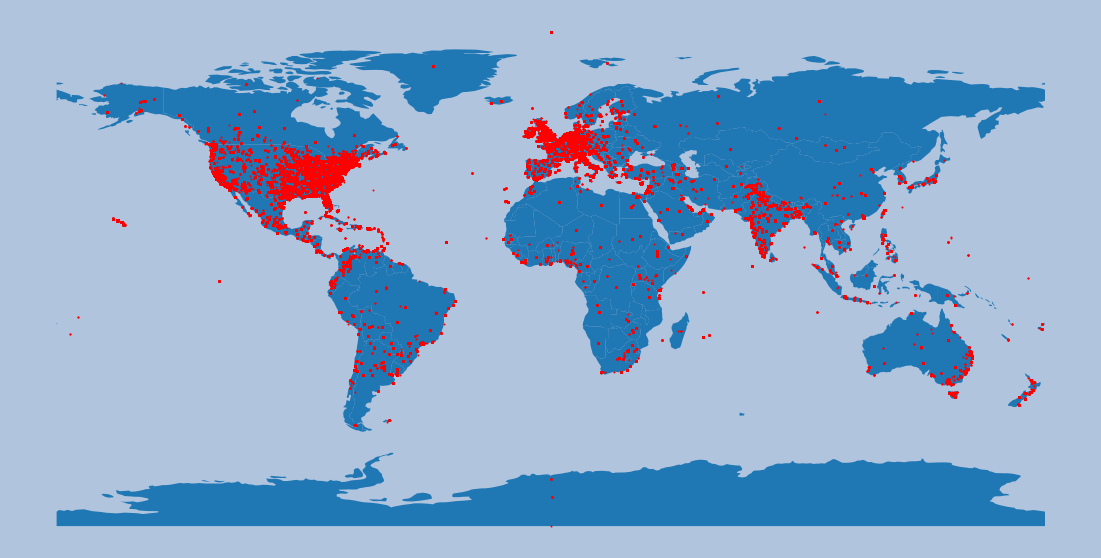

In [55]:
# Plot the location of the tweet origin
fig, ax = plt.subplots(1,figsize=(20,10), facecolor='lightsteelblue')
world.plot(ax=ax)
geo_df.plot(ax=ax, color='r', markersize=1)
ax.axis('off')
plt.show()

In [64]:
# Capture tweet time as date time object for time-series analysis
df_biden['collected_at']=pd.to_datetime(df_biden['collected_at'])
df_trump['collected_at']=pd.to_datetime(df_trump['collected_at'])
df_biden['created_at']=pd.to_datetime(df_biden['created_at'])
df_trump['created_at']=pd.to_datetime(df_trump['created_at'])
df_biden['created_at_r']=df_biden['created_at'].dt.strftime('%Y-%m-%d %H')
df_trump['created_at_r']=df_trump['created_at'].dt.strftime('%Y-%m-%d %H')
df_biden['created_at_r2']=df_biden['created_at'].dt.strftime('%m-%d')
df_trump['created_at_r2']=df_trump['created_at'].dt.strftime('%m-%d')

# Visualize tweet source, platform published and counts

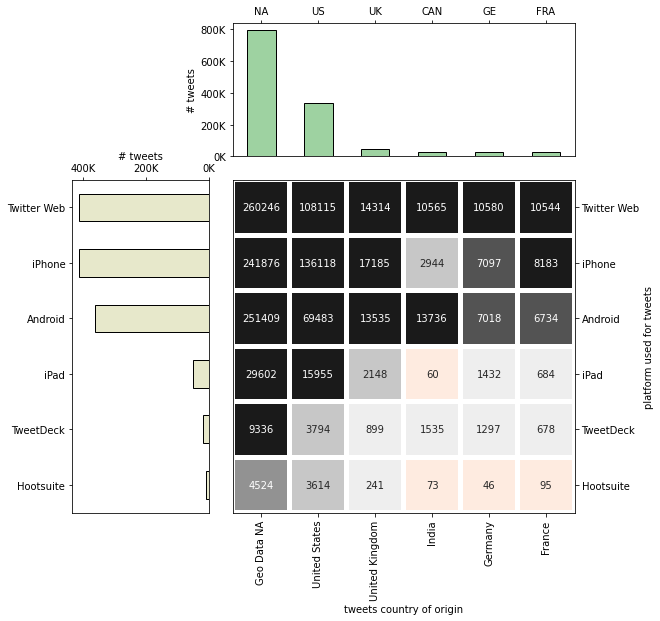

In [57]:
# Group tweets by country of origin
source_dataframe = pd.concat([df_biden[['source','tweet','country']].copy(),df_trump[['source','tweet','country']].copy()])
source_dataframe['country'].replace({'United States of America':'United States'}, inplace=True)
source_dataframe = source_dataframe.fillna('Geo Data NA')
source_dataframe = source_dataframe.drop_duplicates()

# Get the tweets from the top 6 countries of origin 
sources = pd.DataFrame(source_dataframe.groupby(['source'])['tweet'].count().sort_values(ascending=False)[:6])
sources = sources.reset_index()
sourceslist = sources.source.to_list()
country = pd.DataFrame(source_dataframe.groupby(['country'])['tweet'].count().sort_values(ascending=False)[:6])
country = country.reset_index()
countrylist = country.country.to_list()
platXtab = pd.DataFrame(source_dataframe.groupby(['source','country'])['tweet'].count().unstack().fillna(0))

# Plot the heatmap capturing count of tweets per country of origin
def visualize_heatmap(dataframe, list1, list2, heatmap_args, side_axis_xlabel, side_axis_ylabel, side_axis_yticklabels, barcolors, barstyle,
                      formatter, top_box_xticklabels, top_box_xlabel, top_box_ylabel, left_box_yticklabels, left_box_xlabel, left_box_ylabel, bar_ax_set_ylim, barh_ax_set_xlim, fig_size_tuple):
  fig, ax = plt.subplots(2,2, figsize=fig_size_tuple, 
                     gridspec_kw={'height_ratios':[2,5], 'width_ratios':[2,5], 'wspace':0.1, 'hspace':0.1})
  hide_ax = ax[0,0]
  hide_axes(hide_ax)
  side_axis = ax[1,1]
  draw_heatmap(dataframe.loc[list1, list2], side_axis, heatmap_args)
  side_axis.set_xlabel(side_axis_xlabel)
  side_axis.set_ylabel(side_axis_ylabel)
  side_axis.set_yticklabels(side_axis_yticklabels, rotation=0) 

  # Associate heatmap with country name
  top_box = ax[0,1]
  dataframe.loc[list1, list2].sum().plot.bar(ax=top_box, color=barcolors[1], **barstyle)
  top_box.set_xlabel(top_box.get_xlabel())
  top_box.xaxis.tick_top()
  top_box.xaxis.set_label_position("top")
  if formatter != None:
    top_box.yaxis.set_major_formatter(formatter)
  if bar_ax_set_ylim != None:
    top_box.set_ylim(bar_ax_set_ylim)
  top_box.set_xticklabels(top_box_xticklabels, rotation=0) 
  top_box.set_xlabel(top_box_xlabel)
  top_box.set_ylabel(top_box_ylabel)

  # Plot the platform on which tweet published
  left_box = ax[1,0]
  dataframe.loc[list1, list2].sum(axis=1)[::-1].plot.barh(ax=left_box, color=barcolors[2],**barstyle)
  left_box.yaxis.set_label_position("left")
  left_box.xaxis.tick_top()
  left_box.xaxis.set_label_position("top")
  if formatter != None:
    left_box.xaxis.set_major_formatter(formatter)
  left_box.set_xlim(left_box.get_xlim()[::-1])
  if barh_ax_set_xlim != None:
    left_box.set_xlim(barh_ax_set_xlim)
  left_box.set_yticklabels(left_box_yticklabels, rotation=0) 
  left_box.set_xlabel(left_box_xlabel)
  left_box.set_ylabel(left_box_ylabel)
  plt.show()

visualize_heatmap(platXtab, sourceslist, countrylist, heatmap1_args, 'tweets country of origin', 'platform used for tweets', ('Twitter Web', 'iPhone', 'Android', 'iPad', 'TweetDeck', 'Hootsuite'), barcolors, barstyle,
                      formatterK1, ('NA', 'US', 'UK', 'CAN', 'GE', 'FRA'), '', '# tweets', ('Hootsuite', 'TweetDeck', 'iPad', 'Android', 'iPhone', 'Twitter Web'), '# tweets', '', None, None, (9,9))

# Visualize tweet language

In [58]:
# Function to detect the tweet language
from langdetect import detect
def detect_tweetlang(tweet):
    try:
        return detect(tweet)
    except:
        return 'unknown'

# Combine Biden, Trump in a language dataframe to perform language detection
lang_df=pd.concat([df_biden[['tweet','country']].copy(),df_trump[['tweet','country']].copy()])
lang_df['country'].replace({'United States of America':'United States'}, inplace=True)
lang_df=lang_df.fillna('Geo Data NA')
lang_df=lang_df.drop_duplicates()

# Randomly sample data for langauge detection
lang_smdf=lang_df.sample(n=4000).copy()
lang_smdf['lang'] = lang_smdf['tweet'].apply(detect_tweetlang)

# Select top five languages of tweets
langs=pd.DataFrame(lang_smdf.groupby(['lang'])['tweet'].count().sort_values(ascending=False)[:5])
langs=langs.reset_index()
langslst=langs.lang.to_list()

# Select the top and five countries or origin of tweets
country=pd.DataFrame(lang_smdf.groupby(['country'])['tweet'].count().sort_values(ascending=False)[:5])
country=country.reset_index()
countrylst=country.country.to_list()

# Create a crosstab to feed data to heatmap
langXtab=pd.crosstab(lang_smdf.lang, lang_smdf.country, normalize=True)

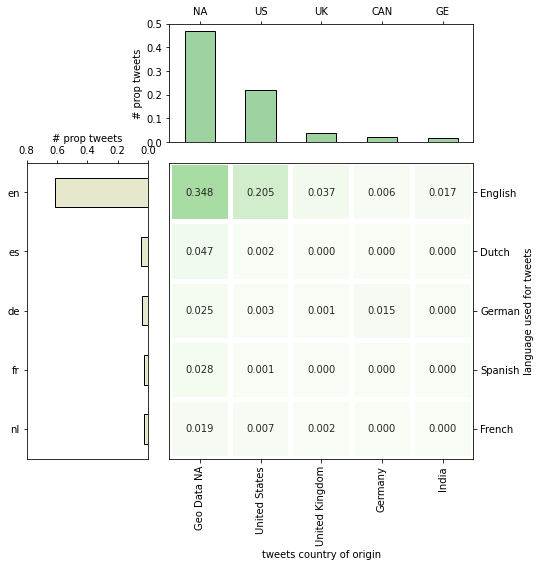

In [59]:
# Plot the tweet language heatmap
visualize_heatmap(langXtab, langslst, countrylst, heatmap2_args, 'tweets country of origin', 'language used for tweets', ('English', 'Dutch', 'German','Spanish','French'), barcolors, barstyle,
                      None, ('NA', 'US', 'UK', 'CAN', 'GE', 'FRA'), '', '# prop tweets', langslst[::-1], '# prop tweets', '', [0, 0.5], [0.8, 0], (8,8))

# Visualize the bi, tri-gram of all USA tweets

In [ ]:
# Obtain tweets only from data that has Geo Data from the US
text1=df_biden.loc[df_biden['country'] == 'United States of America']['tweet']
text2=df_trump.loc[df_trump['country'] == 'United States of America']['tweet']

In [ ]:
# Obtain top 10 Bi and Tri Ngrams from cleaned data
words1 = custom_lemmatize(''.join(str(text1.apply(clean_tweet).tolist())))
words2 = custom_lemmatize(''.join(str(text2.apply(clean_tweet).tolist())))

biden_2ngrams=(pd.Series(nltk.ngrams(words1, 2)).value_counts())[:10]
trump_2ngrams=(pd.Series(nltk.ngrams(words2, 2)).value_counts())[:10]
biden_3ngrams=(pd.Series(nltk.ngrams(words1, 3)).value_counts())[:10]
trump_3ngrams=(pd.Series(nltk.ngrams(words2, 3)).value_counts())[:10]

# Input Bi and Tri Ngrams into dataframes for plotting
biden_ngrams=pd.concat([biden_2ngrams,biden_3ngrams])
trump_ngrams=pd.concat([trump_2ngrams,trump_3ngrams])

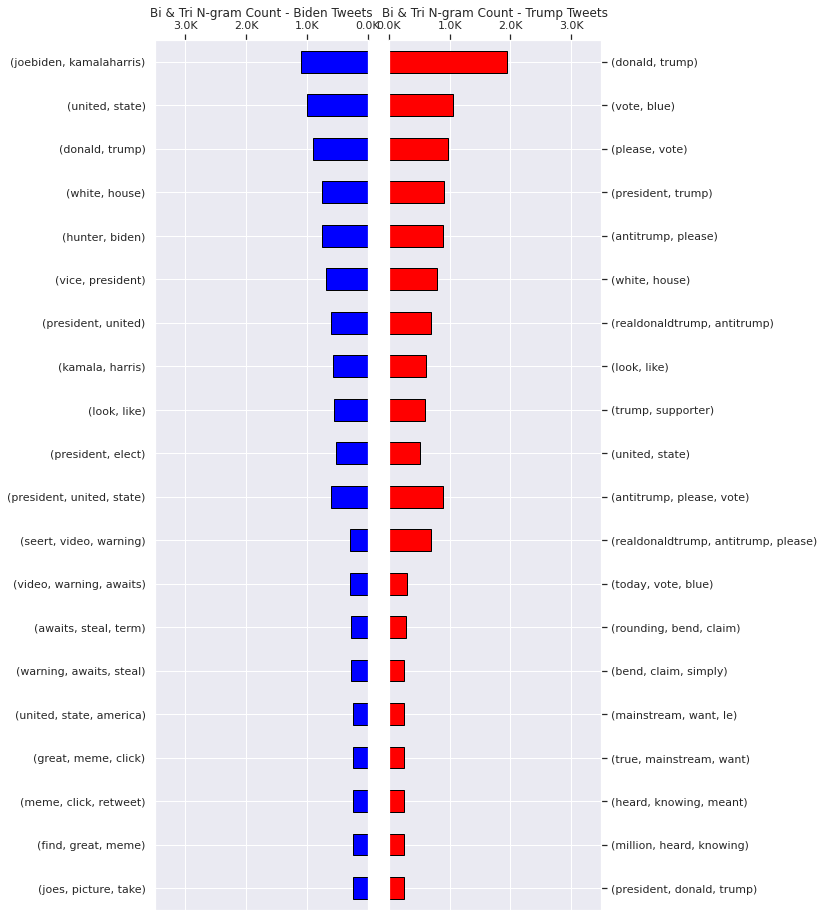

In [ ]:
# Plot the bi and trigram for Biden, Trump tweets
generate_ngram(biden_ngrams, trump_ngrams, "Bi & Tri N-gram Count - Biden Tweets", "Bi & Tri N-gram Count - Trump Tweets", 1)

# Word cloud of Biden tweets

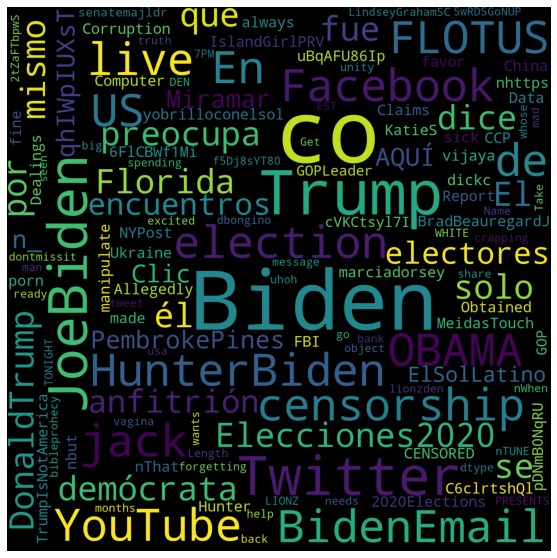

In [ ]:
# Plot the word cloud of Biden tweets
generate_word_cloud(stop_words, text1)

# Word cloud of Trump tweets

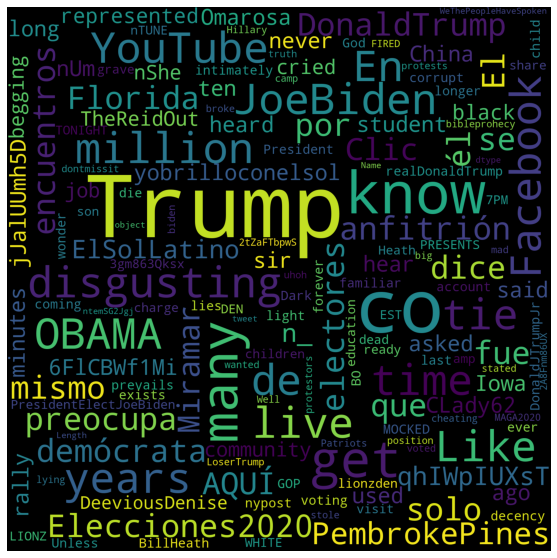

In [ ]:
# Plot the word cloud of Trump tweets
generate_word_cloud(stop_words, text2)

# Use collective wisdom to label 1.7 million tweets referencing the 2 presidential candidates

# Aggregate sentiments and skepticisms for all 2020 tweets

In [65]:
# Import Sentiment Analysis packages
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment import SentimentAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


True

In [66]:
# Function to get the sentiment polarities
def sentiment(data):
    temp=[]
    for row in data:
        tmp=sid.polarity_scores(row)
        temp.append(tmp)
    return temp

In [67]:
# Obtain sentiment scores for both Biden and Trump tweets
sid = SentimentIntensityAnalyzer()
df_biden['VADAR']=sentiment(df_biden['preprocessed_tweet'])
df_trump['VADAR']=sentiment(df_trump['preprocessed_tweet'])
df_biden['compound']  = df_biden['VADAR'].apply(lambda score_dict: score_dict['compound'])
df_trump['compound']  = df_trump['VADAR'].apply(lambda score_dict: score_dict['compound'])
df_biden['type']  = df_biden['compound'].apply(lambda x: 'real' if x > 0.05 else 'fake')
df_trump['type']  = df_trump['compound'].apply(lambda x: 'real' if x > 0.05 else 'fake')

In [68]:
# Merge Biden, Trump datasets for model evaluation
df_merged=pd.concat([df_trump, df_biden])
# Prune unwanted columns from 2020 tweets - collective wisdom
df_merged = df_merged[['preprocessed_tweet', 'type']]
df_merged.columns = ['preprocessed_tweet','type']
df_merged.head(3)

,preprocessed_tweet,type
0,elecciones en florida joebiden dice que donaldtrump solo se preocupa por él mismo el demócrata fue anfitrión de encuentros de electores en pembrokepines miramar clic aquí _ elsollatino yobrilloconelsol flcbwf mi,fake
1,usa trump contro facebook twitter coprono biden donaldtrump ceurhe vp jidljoon,fake
2,trump as student used to hear for years for ten years heard china in and we have and they don know how many we have and asked them how many do we have and they said sir we don know but we have millions like million um what,real


In [69]:
# Prune unwanted columns from all news - reputed news outlets, human verified
all_news = all_news[['preprocessed_tweet', 'type']]
all_news.columns = ['preprocessed_tweet','type']
all_news.head(3)

,preprocessed_tweet,type
0,print they should pay all the back all the money plus interest the entire family and everyone who came in with them need to be deported asap why did it take two years to bust them here we go again another group stealing from the government and taxpayers group of somalis stole over four million in government benefits over just months we ve reported on numerous cases like this one where the muslim refugees immigrants commit fraud by scamming our system it way out of control more related,fake
1,why did attorney general loretta lynch plead the fifth barracuda brigade print the administration is blocking congressional probe into cash payments to iran of course she needs to plead the th she either can recall refuses to answer or just plain deflects the question straight up corruption at its finest percentfedup com talk about covering your ass loretta lynch did just that when she plead the fifth to avoid incriminating herself over payments to iran corrupt to the core attorney general loretta lynch is declining to comply with an investigation by leading members of congress about the obama administration secret efforts to send iran billion in cash earlier this year prompting accusations that lynch has pleaded the fifth amendment to avoid incriminating herself over these payments according to lawmakers and communications exclusively obtained by the washington free beacon sen marco rubio fla and rep mike pompeo kan initially presented lynch in october with series of questions about how the cash payment to iran was approved and delivered in an oct response assistant attorney general peter kadzik responded on lynch behalf refusing to answer the questions and informing the lawmakers that they are barred from publicly disclosing any details about the cash payment which was bound up in ransom deal aimed at freeing several american hostages from iran the response from the attorney general office is unacceptable and provides evidence that lynch has chosen to essentially plead the fifth and refuse to respond to inquiries regarding her role in providing cash to the world foremost state sponsor of terrorism rubio and pompeo wrote on friday in follow up letter to lynch more related,fake
2,red state fox news sunday reported this morning that anthony weiner is cooperating with the fbi which has re opened yes lefties re opened the investigation into hillary clinton classified emails watch as chris wallace reports the breaking news during the panel segment near the end of the show and the news is breaking while we re on the air our colleague bret baier has just sent us an mail saying he has two sources who say that anthony weiner who also had co ownership of that laptop with his estranged wife huma abedin is cooperating with the fbi investigation had given them the laptop so therefore they didn need warrant to get in to see the contents of said laptop pretty interesting development targets of federal investigations will often cooperate hoping that they will get consideration from judge at sentencing given weiner well known penchant for lying it hard to believe that prosecutor would give weiner deal based on an agreement to testify unless his testimony were very strongly corroborated by hard evidence but cooperation can take many forms and as wallace indicated on this morning show one of those forms could be signing consent form to allow the contents of devices that they could probably get warrant for anyway we ll see if weiner cooperation extends beyond that more related,fake


# Merge fact-checked corpus and the aggregated sentiment corpus for model evaluation


In [70]:
# Merge both the fact-checked corpus and the aggregated sentiment corpus for model evaluation
all_tweets = pd.concat([all_news, df_merged])
all_tweets.isnull().sum()

preprocessed_tweet    0
type                  0
dtype: int64

In [71]:
# Print corpus size of real and fake news
print("Tweets classified relaying news in corpus", all_tweets['type'][all_tweets['type']=="real"].shape)
print("Tweets classfied relaying fake news in corpus", all_tweets['type'][all_tweets['type']=="fake"].shape)

Tweets classified relaying news in corpus (559652,)
Tweets classfied relaying fake news in corpus (1216818,)


# Linguistic feature extraction using BoW, Bag of N-grams and TF/IDF variants

# Utility APIs for linguistic tweet analysis

In [72]:
# Extract tweet features using the selected method
# method 1: BoW
# method 2: BoW with Tf-Idf
# method 3: Bag of N-grams
# method 4: Bag of N-grams with Tf-IDF
def extract_features(df, method):
  if (method == 1):
    # BoW
    features = CountVectorizer(max_features=1000) 
    X = features.fit_transform(df['preprocessed_tweet'].tolist()).toarray()
  elif (method == 2):
    # BoW with Tf-Idf
    features = TfidfVectorizer(use_idf=True, max_features=2000) 
    X = features.fit_transform(df['preprocessed_tweet'].tolist()).toarray()
  elif (method == 3):
    # Bag of N-grams
    features = CountVectorizer(ngram_range=(1,3))
    X = features.fit_transform(df['preprocessed_tweet'])  
  elif (method == 4):
    # Bag of N-grams with Tf-Idf  
    features = TfidfVectorizer(use_idf=True, ngram_range=(1,3))
    X = features.fit_transform(df['preprocessed_tweet'])  
  return X

# Data Reduction - Use only a sample of tweets for feature extraction to meet collab RAM requirements

In [73]:
# Sample 7% of tweets for feature extraction
sample_all_tweets = all_tweets.sample(frac=.07)
sample_all_tweets.shape

(124353, 2)

# Linguistic feature extraction

# BoW

In [69]:
# Extract tweet features using BoW method
method = 1       
X_BoW = extract_features(sample_all_tweets, method)
X_BoW.shape

# Split the dataset into training and validation sets - 80/20 splits
y_BoW = pd.get_dummies(sample_all_tweets['type'])
y_BoW = y_BoW.iloc[:,1].values
X_train_BoW, X_test_BoW, y_train_BoW, y_test_BoW = train_test_split(X_BoW, y_BoW, test_size = 0.20, random_state = 101, stratify=y_BoW)


# BoW with Tf-IDF

In [70]:
# Extract tweet features using BoW with Tf-IDF method
method = 2      
X_BoW_TfIDF = extract_features(sample_all_tweets, method)
X_BoW_TfIDF.shape

# Split the dataset into training and validation sets - 80/20 splits
y_BoW_TfIDF = pd.get_dummies(sample_all_tweets['type'])
y_BoW_TfIDF = y_BoW_TfIDF.iloc[:,1].values
X_train_BoW_TfIDF, X_test_BoW_TfIDF, y_train_BoW_TfIDF, y_test_BoW_TfIDF = train_test_split(X_BoW_TfIDF, y_BoW_TfIDF, test_size = 0.20, random_state = 101, stratify=y_BoW_TfIDF)

# Bag of N-grams

In [74]:
# Extract tweet features using Bag of N-grams method
method = 3
X_Bag_of_Ngrams = extract_features(sample_all_tweets, method)
X_Bag_of_Ngrams.shape

# Split the dataset into training and validation sets - 80/20 splits
y_Bag_of_Ngrams = pd.get_dummies(sample_all_tweets['type'])
y_Bag_of_Ngrams = y_Bag_of_Ngrams.iloc[:,1].values
X_train_Bag_of_Ngrams, X_test_Bag_of_Ngrams, y_train_Bag_of_Ngrams, y_test_Bag_of_Ngrams = train_test_split(X_Bag_of_Ngrams, y_Bag_of_Ngrams, test_size = 0.20, random_state = 101, stratify=y_Bag_of_Ngrams)


# Bag of N-grams with Tf-IDF

In [75]:
# Extract tweet features using Bag of N-grams with Tf-IDF method
method = 4
X_Bag_of_Ngrams_TFIDF = extract_features(sample_all_tweets, method)
X_Bag_of_Ngrams_TFIDF.shape

# Split the dataset into training and validation sets - 80/20 splits
y_Bag_of_Ngrams_TFIDF = pd.get_dummies(sample_all_tweets['type'])
y_Bag_of_Ngrams_TFIDF = y_Bag_of_Ngrams_TFIDF.iloc[:,1].values
X_train_Bag_of_Ngrams_TFIDF, X_test_Bag_of_Ngrams_TFIDF, y_train_Bag_of_Ngrams_TFIDF, y_test_Bag_of_Ngrams_TFIDF = train_test_split(X_Bag_of_Ngrams_TFIDF, y_Bag_of_Ngrams_TFIDF, test_size = 0.20, random_state = 101, stratify=y_Bag_of_Ngrams_TFIDF)


# Model evaluation - Logistic R, Naive Bayes using sampled linguistic features on all tweets

In [76]:
# Evaluate model performance for different linguistic methods
def evaluate_models_for_method(df, X_train, y_train, X_test, y_test):
  # Select the models to evaluate
  models = []
  models.append(('Logistic Regression' , LogisticRegression(solver='lbfgs')))
  models.append(('Naive Bayes' , MultinomialNB()))
  #models.append(('SVM' , SVC(probability=True)))
  
  # Generate normalized confusion matrices for the models
  results = []
  names = []
  save_accuracy_results = []
  for name, model in models:
    clf = model
    clf.fit(X_train, y_train)
    Y_pred = clf.predict(X_test)
    accu_score = accuracy_score(y_test, Y_pred)
    
    logit_roc_auc = roc_auc_score(y_test, clf.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='AUC (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    print ("----------------------------")
    print(name + " accuracy: " + str(accu_score))
    save_accuracy_results.append([name, accu_score])
    plt.show()
    
    # Plot non-normalized confusion matrix
    titles_options = [("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
      disp = plot_confusion_matrix(clf, X_test, y_test,
                                  display_labels=df.type.unique(),
                                  cmap=plt.cm.Blues,
                                  normalize=normalize)
      disp.ax_.set_title(title)
      print(title)
      print(disp.confusion_matrix)
    plt.show()
  pd.DataFrame(save_accuracy_results, columns=['Algorithm', 'Accuracy'])

Evaluating models for method - Bag of Words


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


----------------------------
Logistic Regression accuracy: 0.8449197860962567


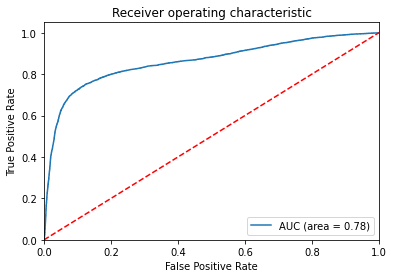

Normalized confusion matrix
[[0.95146089 0.04853911]
 [0.38416719 0.61583281]]


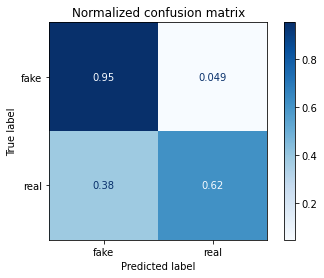

----------------------------
Naive Bayes accuracy: 0.7410638896707008


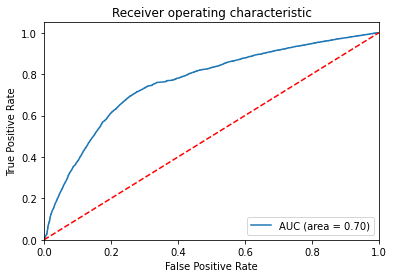

Normalized confusion matrix
[[0.81550424 0.18449576]
 [0.41899937 0.58100063]]


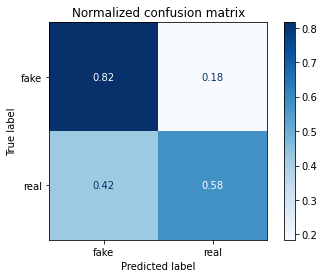

In [74]:
# Evaluate Bag of Words
X_train = X_train_BoW
y_train = y_train_BoW
X_test  = X_test_BoW
y_test  = y_test_BoW
print("Evaluating models for method - Bag of Words")
evaluate_models_for_method(all_tweets, X_train, y_train, X_test, y_test)

Evaluating models for method - Bag of Words with TfIDF


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


----------------------------
Logistic Regression accuracy: 0.880101322825781


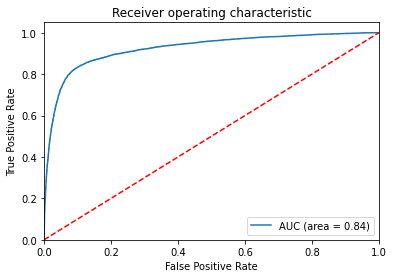

Normalized confusion matrix
[[0.94951697 0.05048303]
 [0.26915769 0.73084231]]


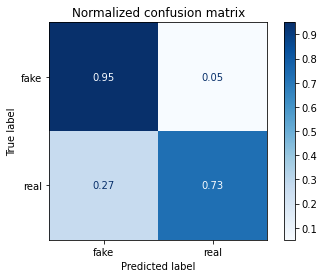

----------------------------
Naive Bayes accuracy: 0.8066422741345342


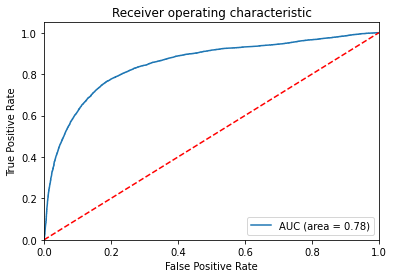

Normalized confusion matrix
[[0.84701932 0.15298068]
 [0.28017733 0.71982267]]


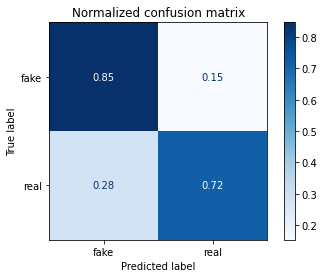

In [75]:
# Evaluate Bag of Words with Tf-IDF
X_train = X_train_BoW_TfIDF
y_train = y_train_BoW_TfIDF
X_test  = X_test_BoW_TfIDF 
y_test  = y_test_BoW_TfIDF
print("Evaluating models for method - Bag of Words with TfIDF")
evaluate_models_for_method(all_tweets, X_train, y_train, X_test, y_test)

Evaluating models for method - Bag of N-grams


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


----------------------------
Logistic Regression accuracy: 0.8937718628121105


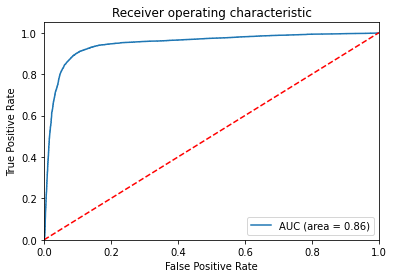

Normalized confusion matrix
[[0.95851913 0.04148087]
 [0.24722116 0.75277884]]


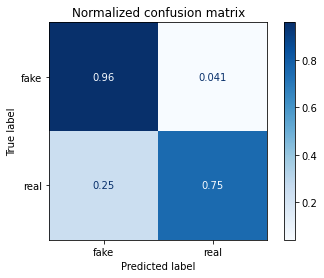

----------------------------
Naive Bayes accuracy: 0.7660327288810261


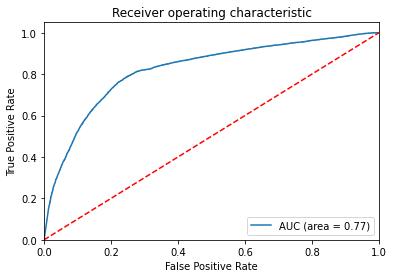

Normalized confusion matrix
[[0.75962215 0.24037785]
 [0.22000767 0.77999233]]


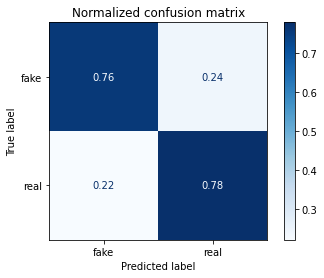

In [77]:
# Evaluate Bag of N-grams
X_train = X_train_Bag_of_Ngrams
y_train = y_train_Bag_of_Ngrams
X_test  = X_test_Bag_of_Ngrams 
y_test  = y_test_Bag_of_Ngrams
print("Evaluating models for method - Bag of N-grams")
evaluate_models_for_method(all_tweets, X_train, y_train, X_test, y_test)

Evaluating models for method Bag of N-grams with TFIDF


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


----------------------------
Logistic Regression accuracy: 0.8367978770455551


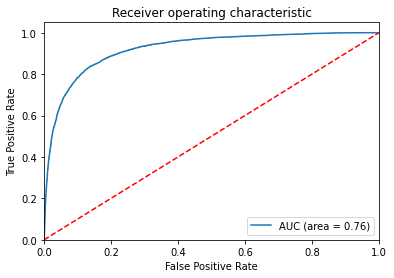

Normalized confusion matrix
[[0.97025346 0.02974654]
 [0.45381372 0.54618628]]


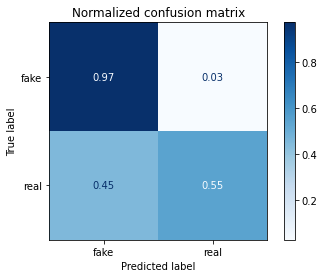

----------------------------
Naive Bayes accuracy: 0.742792810904266


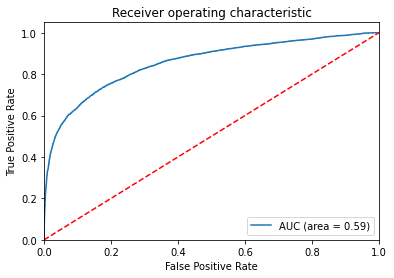

Normalized confusion matrix
[[0.99694907 0.00305093]
 [0.81065542 0.18934458]]


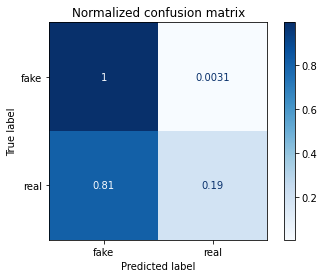

In [78]:
# Evaluate Bag of N-grams with Tf-IDF
X_train = X_train_Bag_of_Ngrams_TFIDF
y_train = y_train_Bag_of_Ngrams_TFIDF
X_test  = X_test_Bag_of_Ngrams_TFIDF 
y_test  = y_test_Bag_of_Ngrams_TFIDF
print("Evaluating models for method Bag of N-grams with TFIDF")
evaluate_models_for_method(all_tweets, X_train, y_train, X_test, y_test)

# Visualize trends in real and fake news in Biden and Trump tweets

In [ ]:
# Prune unwanted columns in biden preprocessed tweets
df_biden_preprocessed_tweets = df_biden[['created_at', 'created_at_r', 'created_at_r2','tweet', 'preprocessed_tweet', 'likes', 'retweet_count', 'type']]
df_biden_preprocessed_tweets.dropna(inplace=True)
df_biden_preprocessed_tweets.reset_index(drop=True, inplace=True)
df_biden_preprocessed_tweets.columns = ['created_at', 'created_at_r', 'created_at_r2','tweet', 'preprocessed_tweet', 'likes', 'retweet_count', 'type']


In [ ]:
# Prune unwanted columns in trump preprocessed tweets
df_trump_preprocessed_tweets = df_trump[['created_at', 'created_at_r', 'created_at_r2', 'tweet', 'preprocessed_tweet', 'likes', 'retweet_count', 'type']]
df_trump_preprocessed_tweets.dropna(inplace=True)
df_trump_preprocessed_tweets.reset_index(drop=True, inplace=True)
df_trump_preprocessed_tweets.columns = ['created_at', 'created_at_r', 'created_at_r2', 'tweet', 'preprocessed_tweet','likes', 'retweet_count', 'type']


In [ ]:
# Perform unit adjustment to likes, retweets when 0
df_biden_preprocessed_tweets['adjusted_likes'] = df_biden_preprocessed_tweets['likes'].apply(lambda x: float(1) if (x ==0 or x == 0.0) else float(x))
df_biden_preprocessed_tweets['adjusted_retweet_count'] = df_biden_preprocessed_tweets['retweet_count'].apply(lambda x: float(1) if (x ==0 or x==0.0) else float(x))
df_biden_preprocessed_tweets["reach_score"] = df_biden_preprocessed_tweets["adjusted_likes"] * df_biden_preprocessed_tweets["adjusted_retweet_count"]


In [ ]:
# Perform unit adjustment to likes, retweets when 0
df_trump_preprocessed_tweets['adjusted_likes'] = df_trump_preprocessed_tweets['likes'].apply(lambda x: float(1) if (x ==0 or x == 0.0) else float(x))
df_trump_preprocessed_tweets['adjusted_retweet_count'] = df_trump_preprocessed_tweets['retweet_count'].apply(lambda x: float(1) if (x ==0 or x==0.0) else float(x))
df_trump_preprocessed_tweets["reach_score"] = df_trump_preprocessed_tweets["adjusted_likes"] * df_trump_preprocessed_tweets["adjusted_retweet_count"]


# Utlity API to plot trends in real and fake news per day

In [74]:
# Plot daily trend fluctations for the last 30 day period
def visualize_reach_score_per_delay(df_biden_trends, df_trump_trends):
  fig, ax=plt.subplots(2,1, figsize=(12,12), gridspec_kw={'hspace':0.05})
 
  # Real News trends
  lineax=ax[0]
  lineax.set_title('Trends in Tweets relaying Real/Fake News per Day')
  sns.lineplot(x='datenum',y='real', data=df_biden_trends, ax=lineax, color='blue', label='Biden Tweets')
  sns.lineplot(x='datenum',y='real', data=df_trump_trends, ax=lineax, color='red', label='Trump Tweets')
  lineax.xaxis.set_major_formatter(fake_dates)
  lineax.set_ylim([0, 100])
  lineax.set_xlabel('')
  lineax.set_ylabel('real (percentage)')
  lineax.axes.get_xaxis().set_ticks([])
  lineax.axes.yaxis.set_ticks([10,20,30,40,50,60,70,80,90,100])   
  lineax.spines['right'].set_visible(False)
  lineax.spines['top'].set_visible(False)
  lineax.spines['bottom'].set_visible(False)

  # Fake News trends
  lineax1=ax[1]
  sns.lineplot(x='datenum',y='fake', data=df_biden_trends, ax=lineax1, color='blue', label='Biden Tweets')
  sns.lineplot(x='datenum',y='fake', data=df_trump_trends, ax=lineax1, color='red', label='Trump Tweets')
  lineax1.xaxis.set_major_formatter(fake_dates)
  lineax1.set_ylim([0, 100])
  lineax1.axes.yaxis.set_ticks([10,20,30,40,50,60,70,80,90,100])   
  lineax1.set_ylabel('fake (percentage)')
  lineax1.set_xlabel('date')
  lineax1.spines['right'].set_visible(False)
  lineax1.spines['top'].set_visible(False)

  plt.show()

In [75]:
# Evaluate trends in real and fake news per day 
sent_t = df_trump_preprocessed_tweets
sent_b = df_biden_preprocessed_tweets

# Get data for the last 30 days
state_bp=sent_b.loc[sent_b['created_at'] < min(sent_b['created_at']) + timedelta(30)]
state_tp=sent_t.loc[sent_t['created_at'] < min(sent_t['created_at']) + timedelta(30)]

state_bp_mean=state_bp.groupby('type')['reach_score'].mean().reset_index()
state_tp_mean=state_tp.groupby('type')['reach_score'].mean().reset_index()
stack_t=sent_t.groupby(['created_at_r','type'])['reach_score'].count().reset_index()
stack_b=sent_b.groupby(['created_at_r','type'])['reach_score'].count().reset_index()

# Get reach score for real news
# For biden dataset
a1=np.array(stack_b.loc[stack_b.type == 'real']['reach_score'].tolist())
dummy = np.array([a1.mean()])
a1 = np.concatenate((a1, dummy))
b1=np.array(stack_b.loc[stack_b.type == 'fake']['reach_score'].tolist())
d1=np.array(stack_b.groupby('created_at_r')['reach_score'].sum().tolist())

# For trump dataset
a2=np.array(stack_t.loc[stack_t.type == 'real']['reach_score'].tolist())
b2=np.array(stack_t.loc[stack_t.type == 'fake']['reach_score'].tolist())
d2=np.array(stack_t.groupby('created_at_r')['reach_score'].sum().tolist())

# Get reach score for fake news
# For biden dataset
SentiDat_b=pd.DataFrame({'date':pd.to_datetime(stack_b.created_at_r.unique()),
                         'datenum':dates.datestr2num(stack_b.created_at_r.unique()),
                         'real':a1*100/d1, 'fake':b1*100/d1})

# For trump dataset
SentiDat_t=pd.DataFrame({'date':pd.to_datetime(stack_t.created_at_r.unique()),
                         'datenum':dates.datestr2num(stack_t.created_at_r.unique()),
                         'real':a2*100/d2,'fake':b2*100/d2})

# Prepare dataframes to visualize trends in real and fake news
# For biden
SentiDat_b1=pd.DataFrame({'date':pd.to_datetime(stack_b.created_at_r.unique()),
                         'datenum':dates.datestr2num(stack_b.created_at_r.unique()),
                         'real':a1.mean()*100/d1.mean(), 'fake':b1.mean()*100/d1.mean()})

# For trump
SentiDat_t1=pd.DataFrame({'date':pd.to_datetime(stack_t.created_at_r.unique()),
                         'datenum':dates.datestr2num(stack_t.created_at_r.unique()),
                         'real':a2.mean()*100/d2.mean(),'fake':b2.mean()*100/d2.mean()})

# Plot the time series trends in real news and misinformation spread

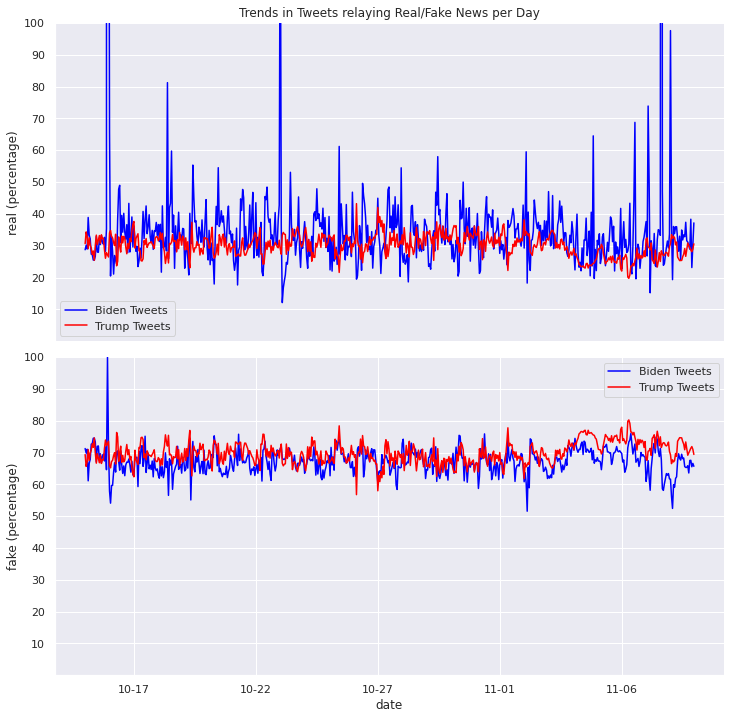

In [76]:
# Plot the reach score of real and fake news as percentage of tweets over time
visualize_reach_score_per_delay(SentiDat_b, SentiDat_t)


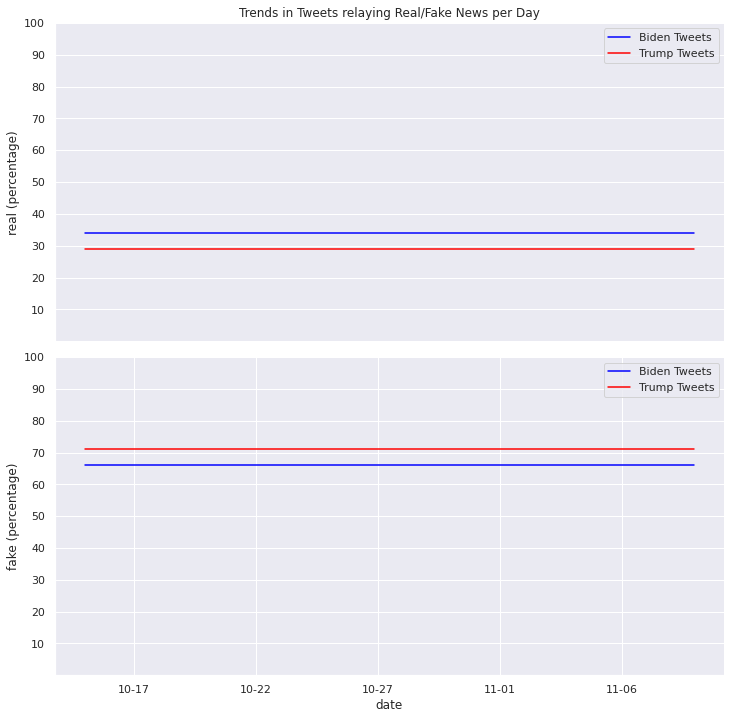

In [77]:
# Plot the mean reach score of real and fake news as percentage of tweets over time
visualize_reach_score_per_delay(SentiDat_b1, SentiDat_t1)